# Kaggle dataset link - 'https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset'

In [1]:
!pip install tensorflow --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 113.1 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompa

# **Import Modules**

In [2]:
import pandas as pd
import numpy as np
import os
import random

import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Sequential

# **Load The Dataset**

In [3]:
TRAIN_DIR = "/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train"

mask_classes = [
    d for d in os.listdir(TRAIN_DIR)
    if os.path.isdir(os.path.join(TRAIN_DIR, d))
]

print("Classes:", mask_classes)


Classes: ['WithoutMask', 'WithMask']


In [4]:
mask_classes

['WithoutMask', 'WithMask']

# **Data Preprocessing**

In [5]:
# Parameters

IMG_SIZE = 224
BATCH_SIZE = 32

mask_classes = ["WithoutMask", "WithMask"]

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    shear_range=0.15,
    horizontal_flip=True
)


val_datagen  = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Face Mask Data

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = 32,
    shuffle= True,
    class_mode = 'binary',
    classes=mask_classes
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = 32,
    shuffle= False,
    class_mode = 'binary',
    classes=mask_classes
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size = 32,
    shuffle= False,
    class_mode = 'binary',
    classes=mask_classes
)


Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [6]:
print(train_generator.class_indices)


{'WithoutMask': 0, 'WithMask': 1}


In [7]:
# Class Names (From Data Generator)

class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)

Class Names: ['WithoutMask', 'WithMask']


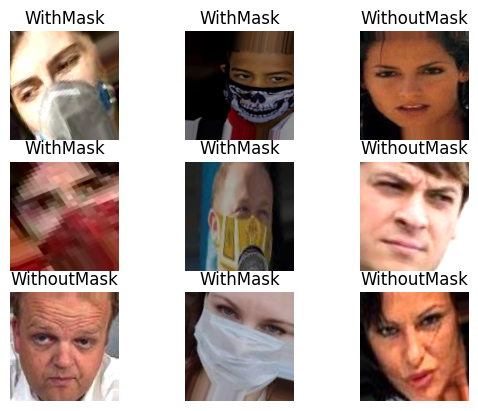

In [8]:
# Visualize Sample Images

for images, labels in train_generator:
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])

    true_index = int(labels[i]) # sparse / binary
    true_label = class_names[true_index]
    plt.title(true_label)
    plt.axis('off')

  break

plt.show()



# **Model Building**

In [9]:
from tensorflow.keras.applications import VGG16

In [10]:
# VGG16 Transfer Learning Model

base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.summary()

I0000 00:00:1768659674.473778      24 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768659674.474443      24 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Freeze base

base_model.trainable = False

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
train_generator.num_classes

2

In [13]:
# Functional API approach -. best approach

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16

base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)

# Output layer
outputs = Dense(1, activation="sigmoid")(x)

# Build model
model = Model(inputs=base_model.input, outputs=outputs)

# Compile
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
# Train the model

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
  1/313 ━━━━━━━━━━━━━━━━━━━━ 1:15:37 15s/step - accuracy: 0.5938 - loss: 0.7270

I0000 00:00:1768659692.032507      99 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 177s 521ms/step - accuracy: 0.9046 - loss: 0.3291 - val_accuracy: 0.9862 - val_loss: 0.0312
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 430ms/step - accuracy: 0.9636 - loss: 0.0936 - val_accuracy: 0.9962 - val_loss: 0.0174
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 134s 428ms/step - accuracy: 0.9696 - loss: 0.0808 - val_accuracy: 0.9887 - val_loss: 0.0273
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 430ms/step - accuracy: 0.9751 - loss: 0.0712 - val_accuracy: 0.9937 - val_loss: 0.0183
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 136s 432ms/step - accuracy: 0.9740 - loss: 0.0708 - val_accuracy: 0.9975 - val_loss: 0.0123
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 137s 437ms/step - accuracy: 0.9768 - loss: 0.0644 - val_accuracy: 0.9925 - val_loss: 0.0160
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 138s 439ms/step - accuracy: 0.9799 - loss: 0.0557 - val_accuracy: 0.9900 - val_loss: 0.0200
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 136s 433ms/step - accuracy: 0.9810 - loss: 0.05

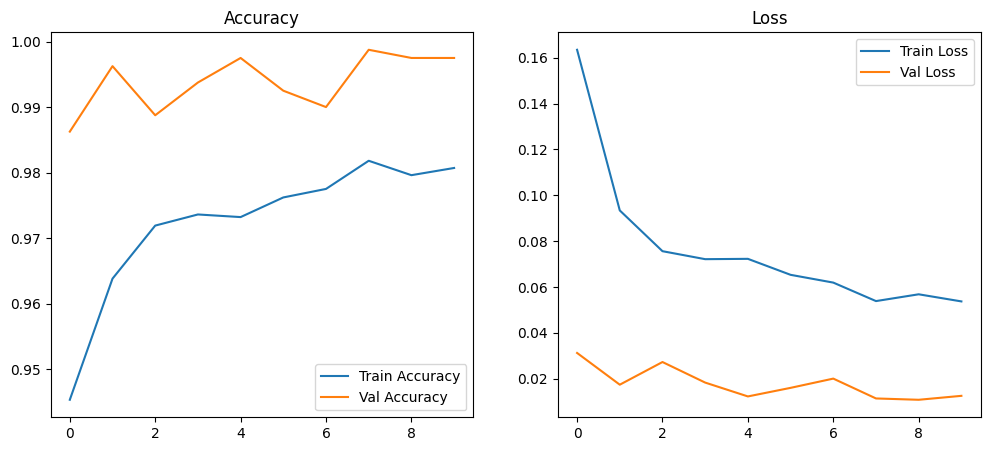

In [15]:
# Plot

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("Loss")
plt.legend()

plt.show()


# **Model Evaluation**

In [16]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {100 * test_accuracy:.2f}%')

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step - accuracy: 0.9886 - loss: 0.0214
Test Accuracy: 99.50%


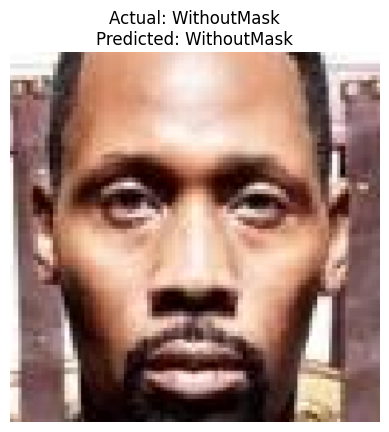

In [17]:
# Predict Random Test Image

for images, labels in test_generator:
    img = images[0]

    # True label
    true_index = int(labels[0])
    true_label = class_names[true_index]

    # Prediction
    predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)

    prob = predictions[0][0]          # ✅ extract scalar value
    pred_index = int(prob > 0.5)      # ✅ threshold
    pred_label = class_names[pred_index]

    plt.imshow(img)
    plt.title(f'Actual: {true_label}\nPredicted: {pred_label}')
    plt.axis('off')
    break


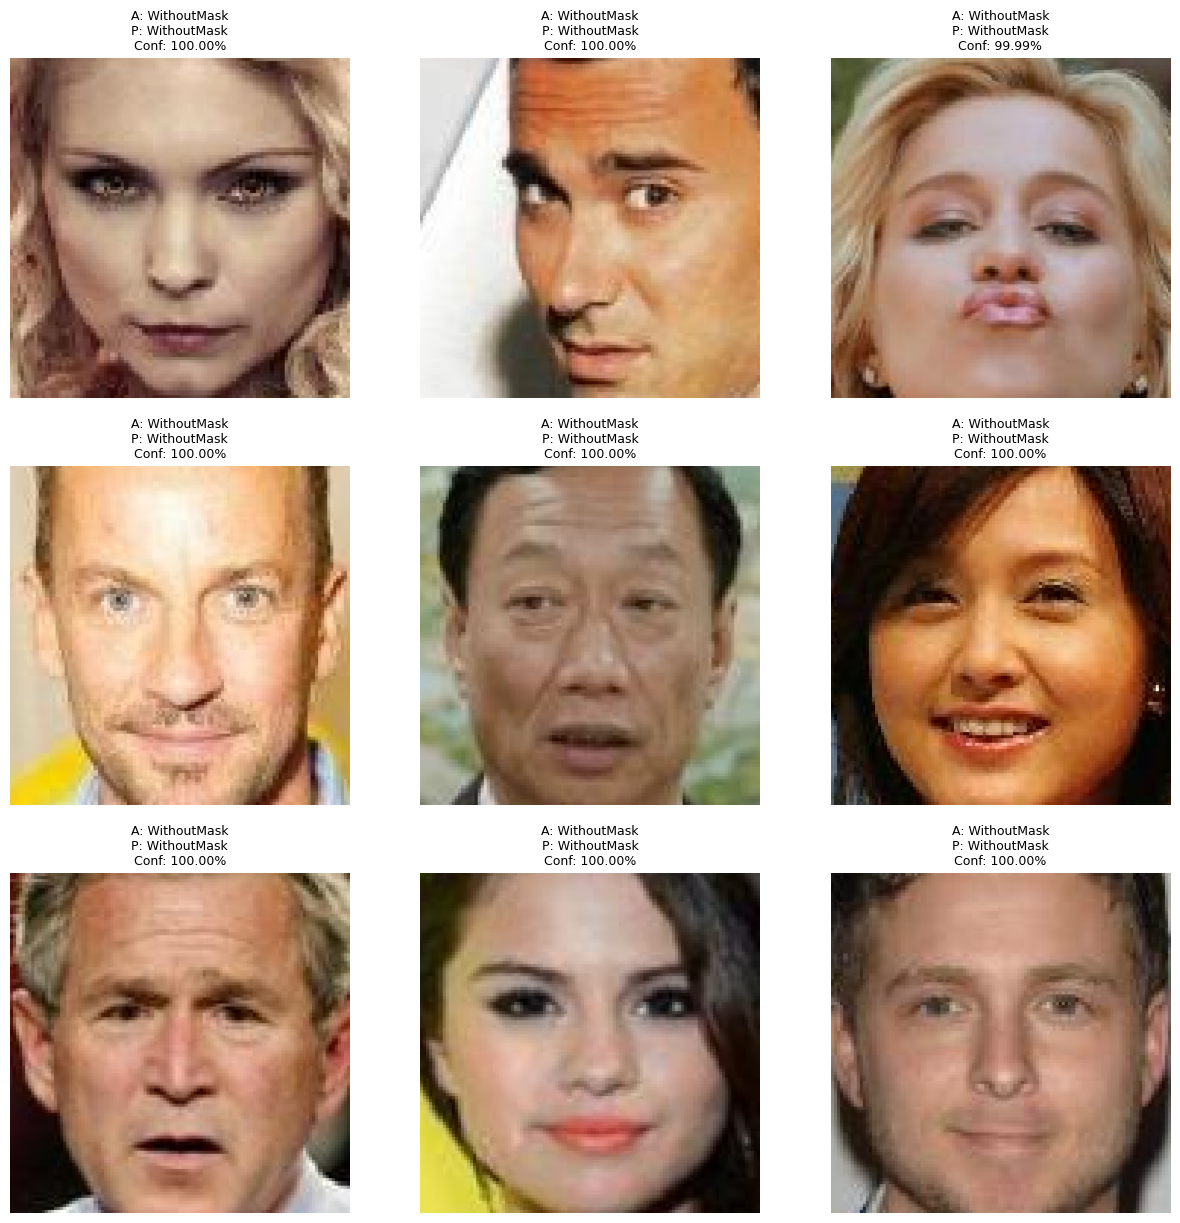

In [18]:
# Multiple Predictions with Confidence

plt.figure(figsize=(15,15))

for images, labels in test_generator:
    for i in range(9):
        img = images[i]

        # True label
        true_index = int(labels[i])
        true_label = class_names[true_index]

        # Prediction
        predictions = model.predict(np.expand_dims(img, axis=0), verbose=0)

        prob = predictions[0][0]          # P(class = 1)
        pred_index = int(prob > 0.5)      # threshold
        pred_label = class_names[pred_index]

        # ✅ Confidence of the predicted class
        if pred_index == 1:
            confidence = prob * 100
        else:
            confidence = (1 - prob) * 100

        # Plot
        plt.subplot(3,3,i+1)
        plt.imshow(img)
        plt.title(
            f"A: {true_label}\n"
            f"P: {pred_label}\n"
            f"Conf: {confidence:.2f}%",
            fontsize=9
        )
        plt.axis("off")
    break

plt.show()


In [19]:
# # Test with External Image

# from tensorflow.keras.preprocessing import image
# import numpy as np
# import matplotlib.pyplot as plt

# img_path = "/content/mask.jpg"   # change if needed

# # Load & preprocess
# img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
# img_array = image.img_to_array(img) / 255.0
# img_array = np.expand_dims(img_array, axis=0)

# # Predict
# prediction = model.predict(img_array, verbose=0)

# prob = prediction[0][0]          # single probability
# pred_index = int(prob > 0.5)     # threshold
# predicted_label = class_names[pred_index]

# # ✅ Confidence of the predicted class
# if pred_index == 1:
#     confidence = prob * 100
# else:
#     confidence = (1 - prob) * 100

# # Show result
# plt.imshow(img)
# plt.axis("off")
# plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2f}%")
# plt.show()


In [20]:
# Save the Model
# model.save("face_mask_vgg16_model_new.h5")
# print("✅ Model saved successfully!")